In [ ]:
#|hide
#| eval: false
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

The current position (before `*args`) suggests it was designed to be usable as either a positional or keyword argument. This can be useful when:

1. You want to maintain backwards compatibility with code that might be calling it positionally
2. You expect it to be commonly used and want to allow shorter calls without keyword names
3. The parameter has special significance that makes it logically part of the "core" arguments rather than optional kwargs

However, given that it's causing parameter conflicts, and modern Python style generally favors explicit keyword arguments for clarity, moving it after `*args` (making it keyword-only) is probably the better design choice unless there's a specific need for positional usage.

In [ ]:
#|default_exp vision.core
#|default_cls_lvl 3

In [ ]:
#|export
from __future__ import annotations
from fastai.torch_basics import *
from fastai.data.all import *

from PIL import Image

try: BILINEAR,NEAREST = Image.Resampling.BILINEAR,Image.Resampling.NEAREST
except AttributeError: from PIL.Image import BILINEAR,NEAREST

In [ ]:
#|export
_all_ = ['BILINEAR','NEAREST']

In [ ]:
from fastai.data.external import *

In [ ]:
#|hide
from nbdev.showdoc import *

In [ ]:
#|export
_all_ = ['Image','ToTensor']

In [ ]:
#|exporti
@patch
def __repr__(x:Image.Image):
    return "<%s.%s image mode=%s size=%dx%d>" % (x.__class__.__module__, x.__class__.__name__, x.mode, x.size[0], x.size[1])

# Core vision

> Basic image opening/processing functionality

## Helpers

In [ ]:
#|export
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
cifar_stats    = ([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
mnist_stats    = ([0.131], [0.308])

In [ ]:
im = Image.open(TEST_IMAGE).resize((30,20))

In [ ]:
#|export
if not hasattr(Image,'_patched'):
    _old_sz = Image.Image.size.fget
    @patch(as_prop=True)
    def size(x:Image.Image): return fastuple(_old_sz(x))
    Image._patched = True

In [ ]:
#|export
@patch(as_prop=True)
def n_px(x: Image.Image): return x.size[0] * x.size[1]

In [ ]:
test_eq(im.n_px, 30*20)

In [ ]:
#|export
@patch(as_prop=True)
def shape(x: Image.Image): return x.size[1],x.size[0]

In [ ]:
test_eq(im.shape, (20,30))

In [ ]:
#|export
@patch(as_prop=True)
def aspect(x: Image.Image): return x.size[0]/x.size[1]

In [ ]:
test_eq(im.aspect, 30/20)

In [ ]:
#|export
@patch
def reshape(x: Image.Image, h, w, resample=0):
    "`resize` `x` to `(w,h)`"
    return x.resize((w,h), resample=resample)

In [ ]:
show_doc(Image.Image.reshape)

---

### Image.reshape

>      Image.reshape (x:PIL.Image.Image, h, w, resample=0)

*`resize` `x` to `(w,h)`*

In [ ]:
test_eq(im.reshape(12,10).shape, (12,10))

In [ ]:
#|export
@patch
def to_bytes_format(im:Image.Image, format='png'):
    "Convert to bytes, default to PNG format"
    arr = io.BytesIO()
    im.save(arr, format=format)
    return arr.getvalue()

In [ ]:
show_doc(Image.Image.to_bytes_format)

---

### Image.to_bytes_format

>      Image.to_bytes_format (im:PIL.Image.Image, format='png')

*Convert to bytes, default to PNG format*

In [ ]:
#|export
@patch
def to_thumb(self:Image.Image, h, w=None):
    "Same as `thumbnail`, but uses a copy"
    if w is None: w=h
    im = self.copy()
    im.thumbnail((w,h))
    return im

In [ ]:
show_doc(Image.Image.to_thumb)

---

### Image.to_thumb

>      Image.to_thumb (h, w=None)

*Same as `thumbnail`, but uses a copy*

In [ ]:
#|export
@patch
def resize_max(x: Image.Image, resample=0, max_px=None, max_h=None, max_w=None):
    "`resize` `x` to `max_px`, or `max_h`, or `max_w`"
    h,w = x.shape
    if max_px and x.n_px>max_px: h,w = fastuple(h,w).mul(math.sqrt(max_px/x.n_px))
    if max_h and h>max_h: h,w = (max_h    ,max_h*w/h)
    if max_w and w>max_w: h,w = (max_w*h/w,max_w    )
    return x.reshape(round(h), round(w), resample=resample)

In [ ]:
test_eq(im.resize_max(max_px=20*30).shape, (20,30))
test_eq(im.resize_max(max_px=300).n_px, 294)
test_eq(im.resize_max(max_px=500, max_h=10, max_w=20).shape, (10,15))
test_eq(im.resize_max(max_h=14, max_w=15).shape, (10,15))
test_eq(im.resize_max(max_px=300, max_h=10, max_w=25).shape, (10,15))

In [ ]:
show_doc(Image.Image.resize_max)

---

### Image.resize_max

>      Image.resize_max (x:PIL.Image.Image, resample=0, max_px=None, max_h=None,
>                        max_w=None)

*`resize` `x` to `max_px`, or `max_h`, or `max_w`*

## Basic types

This section regroups the basic types used in vision with the transform that create objects of those types.

In [ ]:
#|export
def to_image(x):
    "Convert a tensor or array to a PIL int8 Image"
    if isinstance(x,Image.Image): return x
    if isinstance(x,Tensor): x = to_np(x.permute((1,2,0)))
    if x.dtype==np.float32: x = (x*255).astype(np.uint8)
    return Image.fromarray(x, mode=['RGB','CMYK'][x.shape[0]==4])

In [ ]:
#|export
def load_image(fn, mode=None):
    "Open and load a `PIL.Image` and convert to `mode`"
    im = Image.open(fn)
    im.load()
    im = im._new(im.im)
    return im.convert(mode) if mode else im

In [ ]:
#|export
def image2tensor(img):
    "Transform image to byte tensor in `c*h*w` dim order."
    res = tensor(img)
    if res.dim()==2: res = res.unsqueeze(-1)
    return res.permute(2,0,1)

In [ ]:
#|export
class PILBase(Image.Image, metaclass=BypassNewMeta):
    "Base class for a Pillow `Image` that can show itself and convert to a Tensor"
    _bypass_type=Image.Image
    _show_args = {'cmap':'viridis'}
    _open_args = {'mode': 'RGB'}
    @classmethod
    def create(cls, fn:Path|str|Tensor|ndarray|bytes|Image.Image, **kwargs):
        "Return an Image from `fn`"
        if isinstance(fn,TensorImage): fn = fn.permute(1,2,0).type(torch.uint8)
        if isinstance(fn,TensorMask): fn = fn.type(torch.uint8)
        if isinstance(fn,Tensor): fn = fn.numpy()
        if isinstance(fn,ndarray): return cls(Image.fromarray(fn))
        if isinstance(fn,bytes): fn = io.BytesIO(fn)
        if isinstance(fn,Image.Image): return cls(fn)
        return cls(load_image(fn, **merge(cls._open_args, kwargs)))

    def show(self, ctx=None, **kwargs):
        "Show image using `merge(self._show_args, kwargs)`"
        return show_image(self, ctx=ctx, **merge(self._show_args, kwargs))

    def __repr__(self): return f'{self.__class__.__name__} mode={self.mode} size={"x".join([str(d) for d in self.size])}'

In [ ]:
show_doc(PILBase.create)

---

[source](https://github.com/fastai/fastai/blob/master/fastai/vision/core.py#L119){target="_blank" style="float:right; font-size:smaller"}

### PILBase.create

>      PILBase.create
>                      (fn:pathlib.Path|str|torch.Tensor|numpy.ndarray|bytes|PIL
>                      .Image.Image, **kwargs)

*Return an Image from `fn`*

Images passed to `PILBase` or inherited classes' `create` as a PyTorch `Tensor`, NumPy `ndarray`, or Pillow `Image` must already be in the correct Pillow image format. For example, `uint8`, and RGB or BW for `PILImage` or `PILImageBW`, respectively.

In [ ]:
show_doc(PILBase.show)

---

[source](https://github.com/fastai/fastai/blob/master/fastai/vision/core.py#L129){target="_blank" style="float:right; font-size:smaller"}

### PILBase.show

>      PILBase.show (ctx=None, **kwargs)

*Show image using `merge(self._show_args, kwargs)`*

In [ ]:
#|export
class PILImage(PILBase): 
    "A RGB Pillow `Image` that can show itself and converts to `TensorImage`"
    pass

In [ ]:
#|export
class PILImageBW(PILImage):
    "A BW Pillow `Image` that can show itself and converts to `TensorImageBW`"
    _show_args,_open_args = {'cmap':'Greys'},{'mode': 'L'}

In [ ]:
im = PILImage.create(TEST_IMAGE)
test_eq(type(im), PILImage)
test_eq(im.mode, 'RGB')
test_eq(str(im), 'PILImage mode=RGB size=1200x803')

In [ ]:
im2 = PILImage.create(im)
test_eq(type(im2), PILImage)
test_eq(im2.mode, 'RGB')
test_eq(str(im2), 'PILImage mode=RGB size=1200x803')

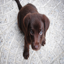

In [ ]:
im.resize((64,64))

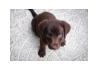

In [ ]:
ax = im.show(figsize=(1,1))

In [ ]:
test_fig_exists(ax)

In [ ]:
timg = TensorImage(image2tensor(im))
tpil = PILImage.create(timg)

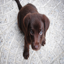

In [ ]:
tpil.resize((64,64))

In [ ]:
#|hide
test_eq(np.array(im), np.array(tpil))

In [ ]:
#|export
class PILMask(PILBase):
    "A Pillow `Image` Mask that can show itself and converts to `TensorMask`"
    _open_args,_show_args = {'mode':'L'},{'alpha':0.5, 'cmap':'tab20'}

In [ ]:
im = PILMask.create(TEST_IMAGE)
test_eq(type(im), PILMask)
test_eq(im.mode, 'L')
test_eq(str(im), 'PILMask mode=L size=1200x803')

In [ ]:
#|export
OpenMask = Transform(PILMask.create)
OpenMask.loss_func = CrossEntropyLossFlat(axis=1)
PILMask.create = OpenMask

### Images

In [ ]:
mnist = untar_data(URLs.MNIST_TINY)
fns = get_image_files(mnist)
mnist_fn = TEST_IMAGE_BW

In [ ]:
timg = Transform(PILImageBW.create)
mnist_img = timg(mnist_fn)
test_eq(mnist_img.size, (28,28))
assert isinstance(mnist_img, PILImageBW)
mnist_img

### Segmentation masks

In [ ]:
#|export
class AddMaskCodes(Transform):
    "Add the code metadata to a `TensorMask`"
    def __init__(self, codes=None):
        self.codes = codes
        if codes is not None: self.vocab,self.c = codes,len(codes)

    def decodes(self, o:TensorMask):
        if self.codes is not None: o.codes=self.codes
        return o

In [ ]:
camvid = untar_data(URLs.CAMVID_TINY)
fns = get_image_files(camvid/'images')
cam_fn = fns[0]
mask_fn = camvid/'labels'/f'{cam_fn.stem}_P{cam_fn.suffix}'

In [ ]:
cam_img = PILImage.create(cam_fn)
test_eq(cam_img.size, (128,96))
tmask = Transform(PILMask.create)
mask = tmask(mask_fn)
test_eq(type(mask), PILMask)
test_eq(mask.size, (128,96))

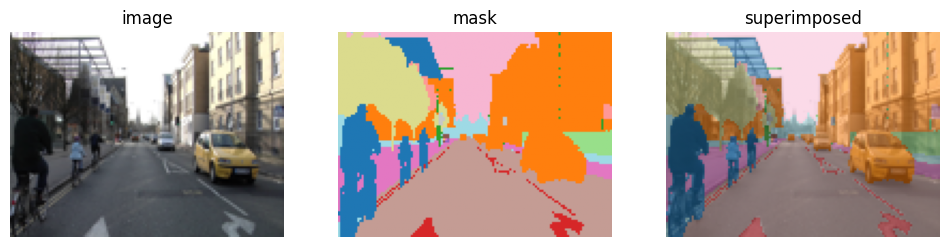

In [ ]:
_,axs = plt.subplots(1,3, figsize=(12,3))
cam_img.show(ctx=axs[0], title='image')
mask.show(alpha=1, ctx=axs[1], vmin=1, vmax=30, title='mask')
cam_img.show(ctx=axs[2], title='superimposed')
mask.show(ctx=axs[2], vmin=1, vmax=30);

### Points

In [ ]:
#|export
class TensorPoint(TensorBase):
    "Basic type for points in an image"
    _show_args = dict(s=10, marker='.', c='r')

    @classmethod
    def create(cls, t, img_size=None)->None:
        "Convert an array or a list of points `t` to a `Tensor`"
        return cls(tensor(t).view(-1, 2).float(), img_size=img_size)

    def show(self, ctx=None, **kwargs):
        if 'figsize' in kwargs: del kwargs['figsize']
        x = self.view(-1,2)
        ctx.scatter(x[:, 0], x[:, 1], **{**self._show_args, **kwargs})
        return ctx

In [ ]:
#|export
TensorPointCreate = Transform(TensorPoint.create)
TensorPointCreate.loss_func = MSELossFlat()
TensorPoint.create = TensorPointCreate

Points are expected to come as an array/tensor of shape `(n,2)` or as a list of lists with two elements. Unless you change the defaults in `PointScaler` (see later on), coordinates should go from 0 to width/height, with the first one being the column index (so from 0 to width) and the second one being the row index (so from 0 to height).

:::{.callout-note}

This is different from the usual indexing convention for arrays in numpy or in PyTorch, but it's the way points are expected by matplotlib or the internal functions in PyTorch like `F.grid_sample`.

:::

In [ ]:
pnt_img = TensorImage(mnist_img.resize((28,35)))
pnts = np.array([[0,0], [0,35], [28,0], [28,35], [9, 17]])
tfm = Transform(TensorPoint.create)
tpnts = tfm(pnts)
test_eq(tpnts.shape, [5,2])
test_eq(tpnts.dtype, torch.float32)

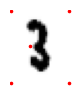

In [ ]:
ctx = pnt_img.show(figsize=(1,1), cmap='Greys')
tpnts.show(ctx=ctx);

### Bounding boxes

In [ ]:
#|export
def get_annotations(fname, prefix=None):
    "Open a COCO style json in `fname` and returns the lists of filenames (with maybe `prefix`) and labelled bboxes."
    annot_dict = json.load(open(fname))
    id2images, id2bboxes, id2cats = {}, collections.defaultdict(list), collections.defaultdict(list)
    classes = {o['id']:o['name'] for o in annot_dict['categories']}
    for o in annot_dict['annotations']:
        bb = o['bbox']
        id2bboxes[o['image_id']].append([bb[0],bb[1], bb[0]+bb[2], bb[1]+bb[3]])
        id2cats[o['image_id']].append(classes[o['category_id']])
    id2images = {o['id']:ifnone(prefix, '') + o['file_name'] for o in annot_dict['images'] if o['id'] in id2bboxes}
    ids = list(id2images.keys())
    return [id2images[k] for k in ids], [(id2bboxes[k], id2cats[k]) for k in ids]

Test `get_annotations` on the coco_tiny dataset against both image filenames and bounding box labels. 

In [ ]:
coco = untar_data(URLs.COCO_TINY)
test_images, test_lbl_bbox = get_annotations(coco/'train.json')
annotations = json.load(open(coco/'train.json'))
categories, images, annots = map(lambda x:L(x),annotations.values())

test_eq(test_images, images.attrgot('file_name'))

def bbox_lbls(file_name):
    img = images.filter(lambda img:img['file_name']==file_name)[0]
    bbs = annots.filter(lambda a:a['image_id'] == img['id'])
    i2o = {k['id']:k['name'] for k in categories}
    lbls = [i2o[cat] for cat in bbs.attrgot('category_id')]
    bboxes = [[bb[0],bb[1], bb[0]+bb[2], bb[1]+bb[3]] for bb in bbs.attrgot('bbox')]
    return [bboxes, lbls]

for idx in random.sample(range(len(images)),5): 
    test_eq(test_lbl_bbox[idx], bbox_lbls(test_images[idx]))

In [ ]:
#|export
from matplotlib import patches, patheffects

In [ ]:
#|export
def _draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(linewidth=lw, foreground='black'), patheffects.Normal()])

def _draw_rect(ax, b, color='white', text=None, text_size=14, hw=True, rev=False):
    lx,ly,w,h = b
    if rev: lx,ly,w,h = ly,lx,h,w
    if not hw: w,h = w-lx,h-ly
    patch = ax.add_patch(patches.Rectangle((lx,ly), w, h, fill=False, edgecolor=color, lw=2))
    _draw_outline(patch, 4)
    if text is not None:
        patch = ax.text(lx,ly, text, verticalalignment='top', color=color, fontsize=text_size, weight='bold')
        _draw_outline(patch,1)

In [ ]:
#|export
class TensorBBox(TensorPoint):
    "Basic type for a tensor of bounding boxes in an image"
    @classmethod
    def create(cls, x, img_size=None)->None: return cls(tensor(x).view(-1, 4).float(), img_size=img_size)

    def show(self, ctx=None, **kwargs):
        x = self.view(-1,4)
        for b in x: _draw_rect(ctx, b, hw=False, **kwargs)
        return ctx

Bounding boxes are expected to come as tuple with an array/tensor of shape `(n,4)` or as a list of lists with four elements and a list of corresponding labels. Unless you change the defaults in `PointScaler` (see later on), coordinates for each bounding box should go from 0 to width/height, with the following convention: x1, y1, x2, y2 where (x1,y1) is your top-left corner and (x2,y2) is your bottom-right corner.

:::{.callout-note}

We use the same convention as for points with x going from 0 to width and y going from 0 to height.

:::

In [ ]:
#|export
class LabeledBBox(L):
    "Basic type for a list of bounding boxes in an image"
    def show(self, ctx=None, **kwargs):
        for b,l in zip(self.bbox, self.lbl):
            if l != '#na#': ctx = retain_type(b, self.bbox).show(ctx=ctx, text=l)
        return ctx

    bbox,lbl = add_props(lambda i,self: self[i])

In [ ]:
coco = untar_data(URLs.COCO_TINY)
images, lbl_bbox = get_annotations(coco/'train.json')
idx=2
coco_fn,bbox = coco/'train'/images[idx],lbl_bbox[idx]
coco_img = timg(coco_fn)

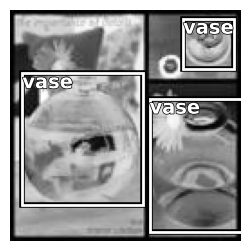

In [ ]:
tbbox = LabeledBBox(TensorBBox(bbox[0]), bbox[1])
ctx = coco_img.show(figsize=(3,3), cmap='Greys')
tbbox.show(ctx=ctx);

## Basic Transforms

Unless specifically mentioned, all the following transforms can be used as single-item transforms (in one of the list in the `tfms` you pass to a `TfmdDS` or a `Datasource`) or tuple transforms (in the `tuple_tfms` you pass to a `TfmdDS` or a `Datasource`). The safest way that will work across applications is to always use them as `tuple_tfms`. For instance, if you have points or bounding boxes as targets and use `Resize` as a single-item transform, when you get to `PointScaler` (which is a tuple transform) you won't have the correct size of the image to properly scale your points.

In [ ]:
#|export
PILImage  ._tensor_cls = TensorImage
PILImageBW._tensor_cls = TensorImageBW
PILMask   ._tensor_cls = TensorMask

In [ ]:
#|export
@ToTensor
def encodes(self, o:PILBase): return o._tensor_cls(image2tensor(o))
@ToTensor
def encodes(self, o:PILMask): return o._tensor_cls(image2tensor(o)[0])

Any data augmentation transform that runs on PIL Images must be run before this transform.

In [ ]:
tfm = ToTensor()
print(tfm)
print(type(mnist_img))
print(type(tfm(mnist_img)))

ToTensor(enc:2,dec:0)
<class '__main__.PILImageBW'>
<class 'fastai.torch_core.TensorImageBW'>


In [ ]:
tfm = ToTensor()
test_eq(tfm(mnist_img).shape, (1,28,28))
test_eq(type(tfm(mnist_img)), TensorImageBW)
test_eq(tfm(mask).shape, (96,128))
test_eq(type(tfm(mask)), TensorMask)

Let's confirm we can pipeline this with `PILImage.create`.

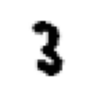

In [ ]:
pipe_img = Pipeline([PILImageBW.create, ToTensor()])
img = pipe_img(mnist_fn)
test_eq(type(img), TensorImageBW)
pipe_img.show(img, figsize=(1,1));

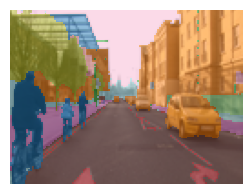

In [ ]:
def _cam_lbl(x): return mask_fn
cam_tds = Datasets([cam_fn], [[PILImage.create, ToTensor()], [_cam_lbl, PILMask.create, ToTensor()]])
show_at(cam_tds, 0);

To work with data augmentation, and in particular the `grid_sample` method, points need to be represented with coordinates going from -1 to 1 (-1 being top or left, 1 bottom or right), which will be done unless you pass `do_scale=False`. We also need to make sure they are following our convention of points being x,y coordinates, so pass along `y_first=True` if you have your data in an y,x format to add a flip.

:::{.callout-warning}

This transform needs to run on the tuple level, before any transform that changes the image size.

:::

In [ ]:
#|export
def _scale_pnts(y, sz, do_scale=True, y_first=False):
    if y_first: y = y.flip(1)
    res = y * 2/tensor(sz).float() - 1 if do_scale else y
    return TensorPoint(res, img_size=sz)

def _unscale_pnts(y, sz): return TensorPoint((y+1) * tensor(sz).float()/2, img_size=sz)

In [ ]:
#|export
class PointScaler(Transform):
    "Scale a tensor representing points"
    order = 1
    def __init__(self, do_scale=True, y_first=False): self.do_scale,self.y_first = do_scale,y_first
    def _grab_sz(self, x):
        self.sz = [x.shape[-1], x.shape[-2]] if isinstance(x, Tensor) else x.size
        return x

    def _get_sz(self, x): return getattr(x, 'img_size') if self.sz is None else self.sz

    def setups(self, dl):
        res = first(dl.do_item(None), risinstance(TensorPoint))
        if res is not None: self.c = res.numel()

    def encodes(self, x:PILBase|TensorImageBase): return self._grab_sz(x)
    def decodes(self, x:PILBase|TensorImageBase): return self._grab_sz(x)

    def encodes(self, x:TensorPoint): return _scale_pnts(x, self._get_sz(x), self.do_scale, self.y_first)
    def decodes(self, x:TensorPoint): return _unscale_pnts(x.view(-1, 2), self._get_sz(x))

To work with data augmentation, and in particular the `grid_sample` method, points need to be represented with coordinates going from -1 to 1 (-1 being top or left, 1 bottom or right), which will be done unless you pass `do_scale=False`. We also need to make sure they are following our convention of points being x,y coordinates, so pass along `y_first=True` if you have your data in an y,x format to add a flip.

:::{.callout-note}

This transform automatically grabs the sizes of the images it sees before a <code>TensorPoint</code> object and embeds it in them. For this to work, those images need to be before any points in the order of your final tuple. If you don't have such images, you need to embed the size of the corresponding image when creating a <code>TensorPoint</code> by passing it with `sz=...`.

:::

In [ ]:
def _pnt_lbl(x): return TensorPoint.create(pnts)
def _pnt_open(fn): return PILImage(PILImage.create(fn).resize((28,35)))
pnt_tds = Datasets([mnist_fn], [_pnt_open, [_pnt_lbl]])
pnt_tdl = TfmdDL(pnt_tds, bs=1, after_item=[PointScaler(), ToTensor()])

In [ ]:
test_eq(pnt_tdl.after_item.c, 10)

In [ ]:
#|hide
#Check the size was grabbed by PointScaler and added to y
tfm = PointScaler()
tfm.as_item=False
x,y = tfm(pnt_tds[0])
test_eq(tfm.sz, x.size)
test_eq(y.img_size, x.size)

In [ ]:
x,y = pnt_tdl.one_batch()
#Scaling and flipping properly done
#NB: we added a point earlier at (9,17); formula below scales to (-1,1) coords
test_close(y[0], tensor([[-1., -1.], [-1.,  1.], [1.,  -1.], [1., 1.], [9/14-1, 17/17.5-1]]))
a,b = pnt_tdl.decode_batch((x,y))[0]
test_eq(b, tensor(pnts).float())
#Check types
test_eq(type(x), TensorImage)
test_eq(type(y), TensorPoint)
test_eq(type(a), TensorImage)
test_eq(type(b), TensorPoint)
test_eq(b.img_size, (28,35)) #Automatically picked the size of the input

/tmp/ipykernel_2154261/311273865.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ctx.scatter(x[:, 0], x[:, 1], **{**self._show_args, **kwargs})


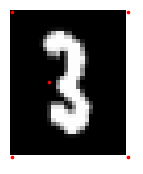

In [ ]:
pnt_tdl.show_batch(figsize=(2,2), cmap='Greys');

In [ ]:
#|export
class BBoxLabeler(Transform):
    def setups(self, dl): self.vocab = dl.vocab

    def decode (self, x, **kwargs):
        self.bbox,self.lbls = None,None
        return self._call('decodes', x, **kwargs)

    def decodes(self, x:TensorMultiCategory):
        self.lbls = [self.vocab[a] for a in x]
        return x if self.bbox is None else LabeledBBox(self.bbox, self.lbls)

    def decodes(self, x:TensorBBox):
        self.bbox = x
        return self.bbox if self.lbls is None else LabeledBBox(self.bbox, self.lbls)

In [ ]:
#|export
#LabeledBBox can be sent in a tl with MultiCategorize (depending on the order of the tls) but it is already decoded.
@MultiCategorize
def decodes(self, x:LabeledBBox): return x

In [ ]:
#|export
@PointScaler
def encodes(self, x:TensorBBox):
    pnts = self.encodes(cast(x.view(-1,2), TensorPoint))
    return cast(pnts.view(-1, 4), TensorBBox)

@PointScaler
def decodes(self, x:TensorBBox):
    pnts = self.decodes(cast(x.view(-1,2), TensorPoint))
    return cast(pnts.view(-1, 4), TensorBBox)

In [ ]:
def _coco_bb(x):  return TensorBBox.create(bbox[0])
def _coco_lbl(x): return bbox[1]

coco_tds = Datasets([coco_fn], [PILImage.create, [_coco_bb], [_coco_lbl, MultiCategorize(add_na=True)]], n_inp=1)
coco_tdl = TfmdDL(coco_tds, bs=1, after_item=[BBoxLabeler(), PointScaler(), ToTensor()])

In [ ]:
#|hide
#Check the size was grabbed by PointScaler and added to y
tfm = PointScaler()
tfm.as_item=False
x,y,z = tfm(coco_tds[0])
test_eq(tfm.sz, x.size)
test_eq(y.img_size, x.size)

In [ ]:
Categorize(add_na=True)

Categorize -- {'vocab': None, 'sort': True, 'add_na': True}
(enc:1,dec:1)

In [ ]:
coco_tds.tfms

(#3) [Pipeline: PILBase.create,Pipeline: _coco_bb,Pipeline: _coco_lbl -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': True}
]

In [ ]:
x,y,z

(PILImage mode=RGB size=128x128,
 TensorBBox([[-0.9011, -0.4606,  0.1416,  0.6764],
             [ 0.2000, -0.2405,  1.0000,  0.9102],
             [ 0.4909, -0.9325,  0.9284, -0.5011]]),
 TensorMultiCategory([1, 1, 1]))

In [ ]:
x,y,z = coco_tdl.one_batch()
test_close(y[0], -1+tensor(bbox[0])/64)
test_eq(z[0], tensor([1,1,1]))
a,b,c = coco_tdl.decode_batch((x,y,z))[0]
test_close(b, tensor(bbox[0]).float())
test_eq(c.bbox, b)
test_eq(c.lbl, bbox[1])

#Check types
test_eq(type(x), TensorImage)
test_eq(type(y), TensorBBox)
test_eq(type(z), TensorMultiCategory)
test_eq(type(a), TensorImage)
test_eq(type(b), TensorBBox)
test_eq(type(c), LabeledBBox)
test_eq(y.img_size, (128,128))

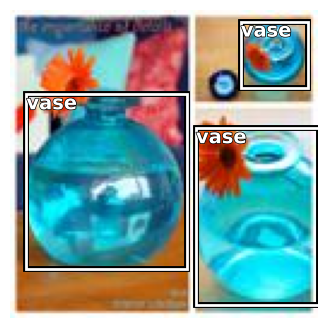

In [ ]:
coco_tdl.show_batch();

In [ ]:
#|hide
#test other direction works too
coco_tds = Datasets([coco_fn], [PILImage.create, [_coco_lbl, MultiCategorize(add_na=True)], [_coco_bb]])
coco_tdl = TfmdDL(coco_tds, bs=1, after_item=[BBoxLabeler(), PointScaler(), ToTensor()])

x,y,z = coco_tdl.one_batch()
test_close(z[0], -1+tensor(bbox[0])/64)
test_eq(y[0], tensor([1,1,1]))
a,b,c = coco_tdl.decode_batch((x,y,z))[0]
test_eq(b, bbox[1])
test_close(c.bbox, tensor(bbox[0]).float())
test_eq(c.lbl, b)

#Check types
test_eq(type(x), TensorImage)
test_eq(type(y), TensorMultiCategory)
test_eq(type(z), TensorBBox)
test_eq(type(a), TensorImage)
test_eq(type(b), MultiCategory)
test_eq(type(c), LabeledBBox)
test_eq(z.img_size, (128,128))

# Export -

In [ ]:
#|hide
from nbdev import nbdev_export
nbdev_export()